In [2]:
import gensim.downloader as api

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# build word2idx
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Dense, Input, Embedding, Lambda
from tensorflow.keras.models import Model

2025-03-18 11:57:09.109415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 11:57:09.315420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
dataset = api.load("text8")

[==================================================] 100.0% 31.6/31.6MB downloaded


The above gives an error:  

```
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)
```

Solution: run with

`--NotebookApp.iopub_data_rate_limit=1.0e10`

But this gives the following message:

```
iopub_data_rate_limit' has moved from NotebookApp to ServerApp. This config will be passed to ServerApp. Be sure to update your config before our next release.
```


In [4]:
type(dataset)

text8.Dataset

In [5]:
# don't do this, the output will get stuck
# for x in dataset:
#   print(x)

i = 0
for x in dataset: # already tokenized
  print(x)
  i += 1
  if i > 2:
    break

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers', 'to', 'related', 'so

In [6]:
i = 0
for x in dataset:
  i += 1
print(i)

1701


In [7]:
doc_lengths = []
for x in dataset:
  l = len(x)
  doc_lengths.append(l)

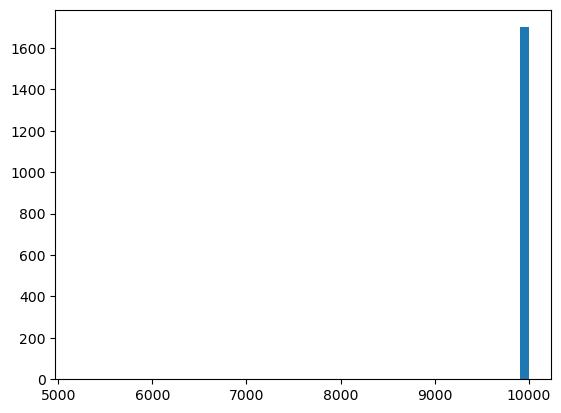

In [8]:
plt.hist(doc_lengths, bins=50);

Almost all documents are of the same length (10000 words)

In [9]:
np.mean(doc_lengths), np.std(doc_lengths)

(9997.182245737802, 116.17898450079628)

In [10]:
vocab_size = 20_000 # NOT 20_000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(dataset)
sequences = tokenizer.texts_to_sequences(dataset)

In [11]:
print(type(sequences))
print(type(sequences[0]))
print(type(sequences[0][0]))

<class 'list'>
<class 'list'>
<class 'int'>


In [12]:
print(len(sequences))      # number of documents
print(len(sequences[0]))   # length of the first document
print(tokenizer.num_words)

1701
9538
20000


In [13]:
print(len(tokenizer.word_index))
# all the words, not just the ones that are kept!

253854


In [14]:
for i, item in enumerate(tokenizer.word_index.items()):
    print(item)
    if i > 10:
        break
# prints sorted by frequency

('the', 1)
('of', 2)
('and', 3)
('one', 4)
('in', 5)
('a', 6)
('to', 7)
('zero', 8)
('nine', 9)
('two', 10)
('is', 11)
('as', 12)


In [15]:
for i, item in enumerate(tokenizer.index_word.items()):
    print(item)
    if i > 10:
        break

(1, 'the')
(2, 'of')
(3, 'and')
(4, 'one')
(5, 'in')
(6, 'a')
(7, 'to')
(8, 'zero')
(9, 'nine')
(10, 'two')
(11, 'is')
(12, 'as')


In [16]:
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [17]:
# build model

# exercise: try other hyperparameters

# context_size: the number of words on both sized of the target word ("middle" word); here: 5 words on left, five words on the right
context_size = 10 #(tried 8 as well on macbook) 
embedding_dim = 50

i = Input(shape=(context_size,))

x = Embedding(vocab_size, embedding_dim)(i)
# output of the embedding has shape N (n_docs) x T (n_tokens) x D (embedding_dim)

# Lambda layer allows you to specify your own function
# axis=1 corresponds to T; therefore the output will have shape N x D
# ??
x = Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)

x = Dense(vocab_size, use_bias=False)(x)

model = Model(i, x)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 10, 50)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20000)          │     1,000,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 2,000,000 (7.63 MB)

 Non-trainable params: 0 (0.00 B)

10 x 50 is the size of the embedding vectors
output needs to have an output for every possible word

In [19]:
half_context_size = context_size // 2

def data_generator(sequences, batch_size=128):
  X_batch = np.zeros((batch_size, context_size))
  Y_batch = np.zeros(batch_size)
  n_batches = int(np.ceil(len(sequences) / batch_size))
  while True: # an infinite generator!
    random.shuffle(sequences)

    # one epoch will be one pass through the data
    for i in range(n_batches):
      batch_sequences = sequences[i * batch_size:(i + 1) * batch_size]

      current_batch_size = len(batch_sequences) # may be less than batch_size
      for ii in range(current_batch_size):
        seq = batch_sequences[ii]
        j = np.random.randint(0, len(seq) - context_size - 1)
        # x1: everything to the left of the middle word
        # x2: everything to the right of the middle word
        x1 = seq[j:j + half_context_size]
        x2 = seq[j + half_context_size + 1:j + context_size + 1]
        # the 2 lines below (commented out) describe what is done conceptually, but is less efficient
        # x = x1 + x2
        # X_batch[ii] = x
        X_batch[ii, :half_context_size] = x1
        X_batch[ii, half_context_size:] = x2
        y = seq[j + half_context_size]
        Y_batch[ii] = y
      
      yield X_batch[:current_batch_size], Y_batch[:current_batch_size]

In [20]:
model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

The cell below always stalls at a certain amount of epochs -- memory problems it seems, but I already changed 
the memory allocated using 
```
c.NotebookApp.max_buffer_size = 1000000000
c.NotebookApp.iopub_data_rate_limit = 1000000
```

but this does not seem to have any effect.
The errors I get:

```
During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/tornado/websocket.py", line 1090, in wrapper
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
Task exception was never retrieved
future: <Task finished name='Task-36041' coro=<WebSocketProtocol13.write_message.<locals>.wrapper() done, defined at /Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/tornado/websocket.py:1086> exception=WebSocketClosedError()>
Traceback (most recent call last):
  File "/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/tornado/websocket.py", line 1088, in wrapper
    await fut
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/tornado/websocket.py", line 1090, in wrapper
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError
Task exception was never retrieved
future: <Task finished name='Task-36042' coro=<WebSocketProtocol13.write_message.<locals>.wrapper() done, defined at /Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/tornado/websocket.py:1086> exception=WebSocketClosedError()>
Traceback (most recent call last):
  File "/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/tornado/websocket.py", line 1088, in wrapper
    await fut
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/michielnoback/opt/miniconda3/envs/nlp/lib/python3.12/site-packages/tornado/websocket.py", line 1090, in wrapper
    raise WebSocketClosedError()
tornado.websocket.WebSocketClosedError

```

In [21]:
# takes about 46 min
batch_size = 128
r = model.fit(
  data_generator(sequences, batch_size),
  # 10000 epochs because each document contains about 10000 words 
  # each epoch takes only one context window from each document and you need to take all possible contaxt windows
  epochs=10000, # from 10000
  # since the data generator is infinite, it needs to know how many steps/batches to take
  steps_per_epoch=int(np.ceil(len(sequences) / batch_size))
)

Epoch 1/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0075 - loss: 9.9032 
Epoch 2/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.0680 - loss: 9.9012
Epoch 3/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0718 - loss: 9.8912
Epoch 4/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.0698 - loss: 9.8565
Epoch 5/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0841 - loss: 9.7698
Epoch 6/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0663 - loss: 9.6050
Epoch 7/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.0627 - loss: 9.3438
Epoch 8/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0569 - loss: 9.0974
Epoch 9/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0802 - loss: 8.6206
Epoch 10/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0729 - loss: 8.1998
Epoch 11/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0636 - loss: 8.0437
Epoch 12/10000
14/14 ━━━━━━━━

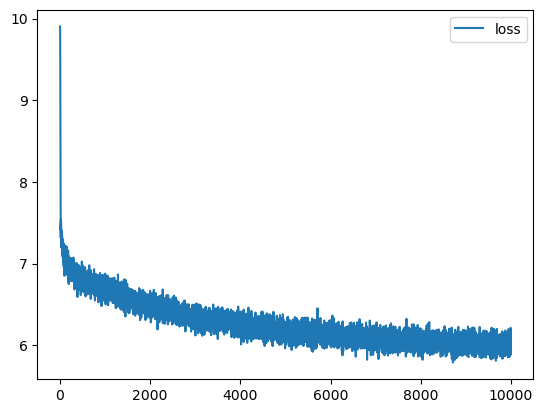

In [22]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.legend();

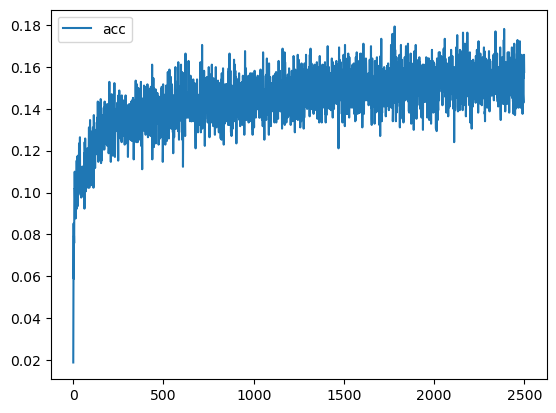

In [21]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.legend();

In [23]:
# Get embedding matrix
embeddings = model.layers[1].get_weights()[0]
embeddings

array([[-0.02410002,  0.03624469,  0.04384006, ...,  0.02396232,
         0.04405816,  0.04269155],
       [ 0.3681039 ,  0.37118888, -0.10663277, ..., -0.04127092,
        -0.2023187 , -0.5215174 ],
       [ 0.00282555,  0.7789915 , -1.1941458 , ...,  0.804221  ,
         1.8329269 , -0.57398   ],
       ...,
       [ 0.01174857, -0.05557818, -0.25920153, ..., -0.14842875,
         0.13143635, -0.840553  ],
       [ 0.17197788,  0.3566376 , -0.1751659 , ...,  0.07676169,
        -0.876873  , -0.6845253 ],
       [ 0.23356226,  0.45621863, -0.41466805, ..., -0.12760672,
         0.08896456,  0.2083998 ]], dtype=float32)

In [24]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
# uses the embeddings matrix to find the nearest neighbors
# uses euclidean distance by default
neighbors.fit(embeddings)

NearestNeighbors(algorithm='ball_tree')

In [25]:
# find neighbors for "queen"
queen_idx = tokenizer.word_index['queen']
queen = embeddings[queen_idx:queen_idx + 1]
distances, indices = neighbors.kneighbors(queen)
indices

array([[ 903, 1061, 2032,  187, 3421]])

In [26]:
for idx in indices[0]:
  word = tokenizer.index_word[idx]
  print(word)

queen
prince
elizabeth
king
princess


In [27]:
def print_neighbors(query_word):
  query_idx = tokenizer.word_index[query_word]
  query = embeddings[query_idx:query_idx + 1]
  distances, indices = neighbors.kneighbors(query)
  for idx in indices[0]:
    word = tokenizer.index_word[idx]
    print(word)

In [28]:
words = ['california', 'japan', 'election', 'uncle', 'paris']
for word in words:
    print(f'\nneigbors for {word}:')
    print_neighbors(word)


neigbors for california:
california
illinois
florida
texas
wisconsin

neigbors for japan:
japan
indonesia
taiwan
pakistan
cuba

neigbors for election:
election
presidential
elections
candidate
senate

neigbors for uncle:
uncle
grandfather
grandmother
nephew
brother

neigbors for paris:
paris
leipzig
florence
venice
vienna


In [29]:
# king - man = queen - woman

def get_embedding(word):
  idx = tokenizer.word_index[word]
  return embeddings[idx:idx + 1]

king = get_embedding('king')
man = get_embedding('man')
woman = get_embedding('woman')
query = king - man + woman

distances, indices = neighbors.kneighbors(query)
for idx in indices[0]:
  word = tokenizer.index_word[idx]
  print(word)

king
emperor
queen
henry
prince


In [30]:
# england - english = australia - australian

king = get_embedding('england')
man = get_embedding('english')
woman = get_embedding('australian')
query = king - man + woman

distances, indices = neighbors.kneighbors(query)
for idx in indices[0]:
  word = tokenizer.index_word[idx]
  print(word)

australia
bank
dallas
texas
virginia
